In [ ]:
pip install fredapi

In [ ]:
pip install yellowbrick

# Analysis of a 60/40 Portfolio's Returns with Machine Learning Models

## Introduction
This project analyzes a balanced 60/40 portfolio composed of global equities (MSCI World Index) and bonds (AGG ETF). The primary goal is to evaluate the impact of macroeconomic variables (Yield Curve, GS10 Rate, Volatility, and Inflation Rate) on portfolio returns using Machine Learning techniques.

The analysis includes:

- **Data Collection and Preprocessing**: Daily financial data and macroeconomic indicators (sourced from FRED) aggregated into monthly frequencies.
- **Exploratory Data Analysis (EDA)**: Visualization of return distributions and macroeconomic variables.
- **Correlation Analysis**: Identifying relationships between variables.
- **Machine Learning Models**:
  - Linear Regression to evaluate linear relationships.
  - Polynomial Regression with parameter optimization using Ridge Regression.
  - Random Forest to capture non-linear relationships and enhance predictive accuracy.

The results feature performance metrics such as R-squared and Mean Squared Error, alongside residual visualizations to assess each model's effectiveness.


In [3]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot
import warnings

# Sopprime gli avvisi
warnings.filterwarnings('ignore')

# Impostazioni dello stile di visualizzazione
sns.set_theme(style='whitegrid')

In [4]:
# Scarica i dati giornalieri dei due titoli
msci_data = yf.download('CSUS.L', start='2014-10-01', end='2024-10-01')
bnd_data = yf.download('AGG', start='2014-10-01', end='2024-10-01')

# Calcoliamo i log rendimenti dei titoli
msci_data['log_return'] = np.log(msci_data['Adj Close'] / msci_data['Adj Close'].shift(1))
bnd_data['log_return'] = np.log(bnd_data['Adj Close'] / bnd_data['Adj Close'].shift(1))

# Rimuoviamo i valori mancanti
msci_data.dropna(inplace=True)
bnd_data.dropna(inplace=True)

# Convertiamo i log rendimenti in frequenza mensile usando 'M' per la fine del mese
msci_monthly_returns = msci_data['log_return'].resample('M').sum()
bnd_monthly_returns = bnd_data['log_return'].resample('M').sum()

# Combiniamo i rendimenti mensili dei due titoli in un unico DataFrame
portfolio_returns = pd.DataFrame({
    'MSCI': msci_monthly_returns,
    'BND': bnd_monthly_returns
})

# Assegniamo pesi ai titoli nel portafoglio
weights = np.array([0.6, 0.4])

# Calcoliamo i rendimenti del portafoglio ponderato
portfolio_returns['Portfolio'] = portfolio_returns[['MSCI', 'BND']].dot(weights)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Dati FRED
fred = Fred(api_key='e6983cbafe58a9a62299754a4770a9ac')

yield_curve = fred.get_series('T10Y2Y')
gs10_rate = fred.get_series('GS10')
vix = fred.get_series('VIXCLS')
inflation_rate = fred.get_series('CPIAUCSL')

# Creiamo un DataFrame per una più semplice manipolazione
macro_data = pd.DataFrame({
    'Yield Curve': yield_curve,
    'GS10 Rate': gs10_rate,
    'Volatility': vix,
    'Inflation Rate': inflation_rate
})

# Impostiamo la frequenza giornaliera e interpoliamo i valori mancanti
macro_data = macro_data.asfreq('D')
macro_data.interpolate(method='linear', inplace=True)

# Filtriamo per mantenere solo i dati che rientrano nell'intervallo di date desiderato
macro_data = macro_data.loc['2014-10-01':'2024-10-01']

# Resampling dei dati macroeconomici alla frequenza mensile
yield_curve_monthly = macro_data['Yield Curve'].resample('M').mean()
gs10_rate_monthly = macro_data['GS10 Rate'].resample('M').mean()
vix_monthly = macro_data['Volatility'].resample('M').mean()
inflation_rate_monthly = macro_data['Inflation Rate'].resample('M').mean()

# Creiamo il DataFrame combinato
monthly_data = pd.DataFrame({
    'Portfolio': portfolio_returns['Portfolio'],
    'Yield Curve': yield_curve_monthly,
    'GS10 Rate': gs10_rate_monthly,
    'Volatility': vix_monthly,
    'Inflation Rate': inflation_rate_monthly
})

# Rimuoviamo eventuali valori mancanti
monthly_data.dropna(inplace=True)

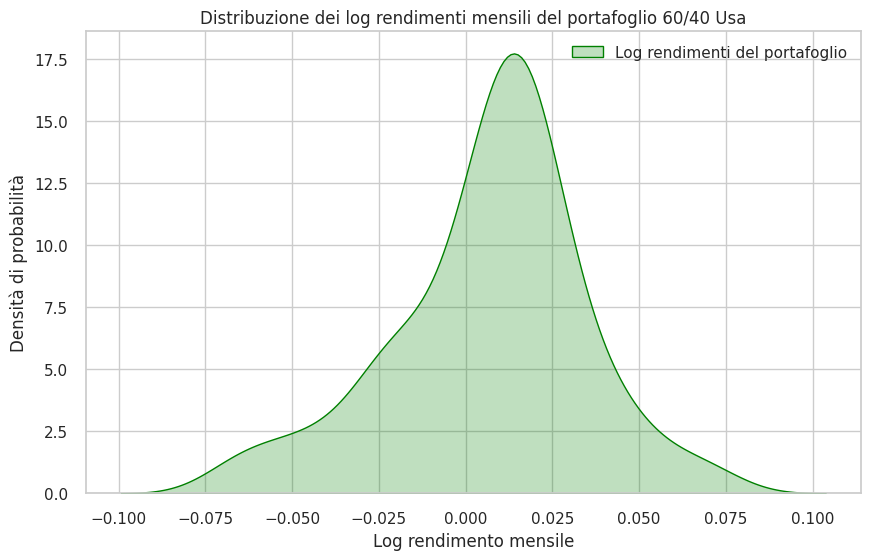

In [6]:
# EXPLORATORY DATA ANALYSIS

# Plottiamo la distribuzione del portafoglio utilizzando KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(monthly_data['Portfolio'], color='green', label='Log rendimenti del portafoglio', fill=True)
plt.title('Distribuzione dei log rendimenti mensili del portafoglio 60/40 Usa')
plt.xlabel('Log rendimento mensile')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.grid(True)
plt.show()

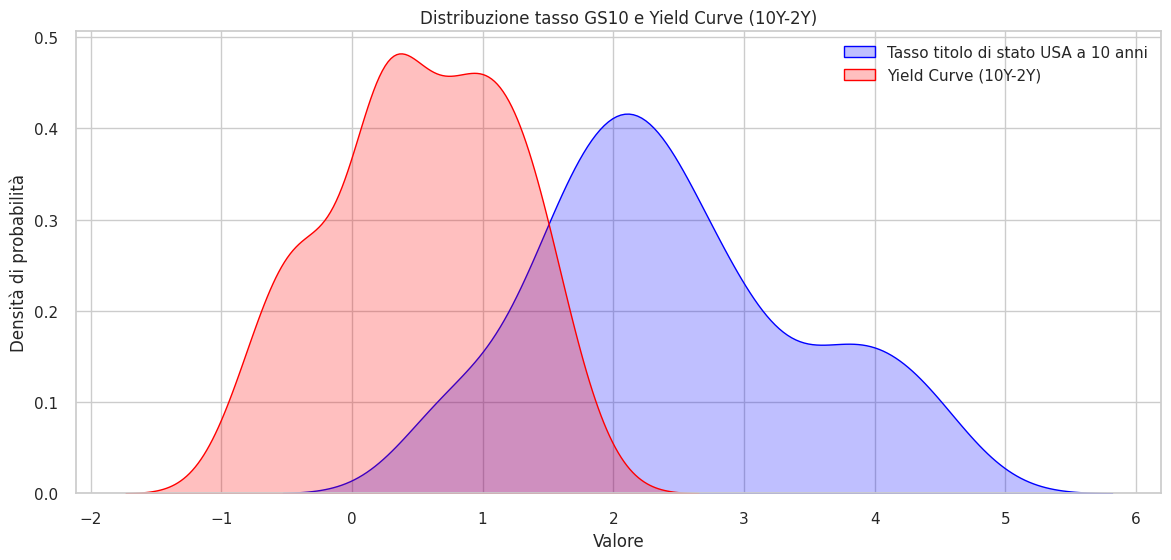

In [7]:
# Plottiamo le distribuzioni del GS10 e della Yield Curve
plt.figure(figsize=(14, 6))
sns.kdeplot(monthly_data['GS10 Rate'], color='blue', label='Tasso titolo di stato USA a 10 anni', fill=True)
sns.kdeplot(monthly_data['Yield Curve'], color='red', label='Yield Curve (10Y-2Y)', fill=True)
plt.title('Distribuzione tasso GS10 e Yield Curve (10Y-2Y)')
plt.xlabel('Valore')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.grid(True)
plt.show()

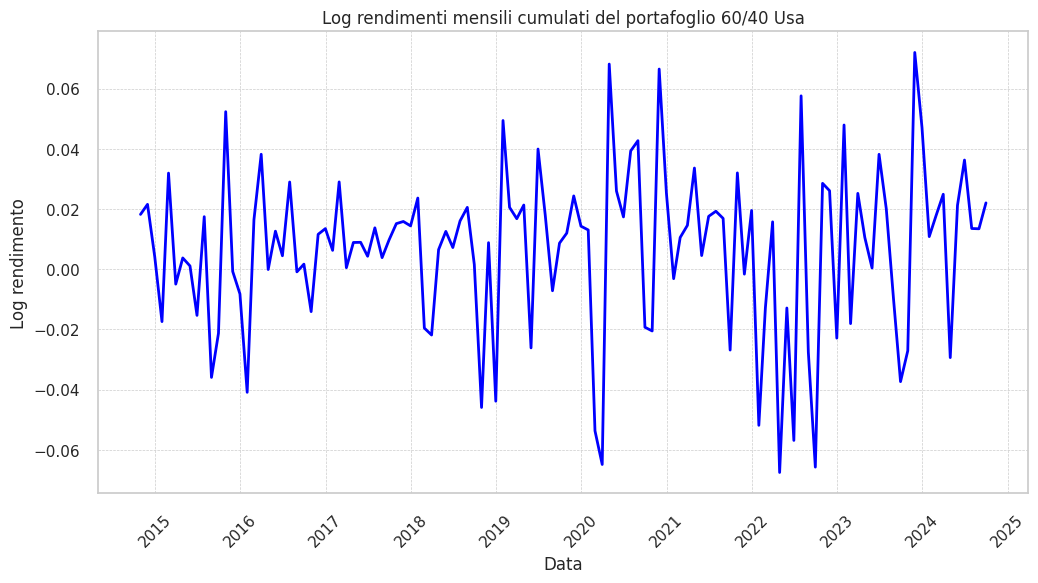

In [8]:
# Grafico dei log rendimenti del portafoglio nel tempo
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Portfolio'], label='Log rendimenti mensili', color='blue', linewidth=2)
plt.title('Log rendimenti mensili cumulati del portafoglio 60/40 Usa')
plt.xlabel('Data')
plt.ylabel('Log rendimento')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

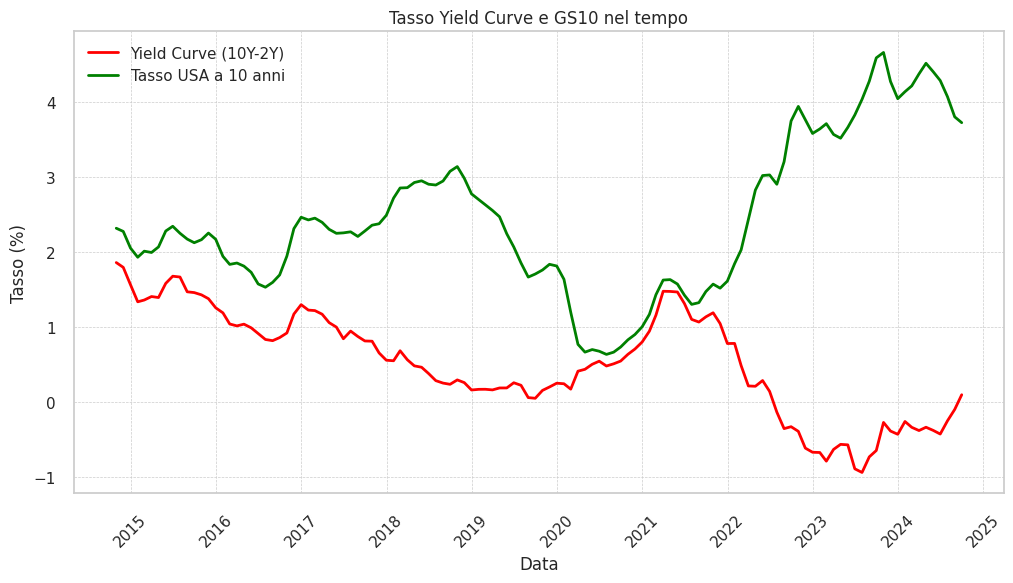

In [9]:
# Grafico della Yield Curve e tasso GS10 nel tempo
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Yield Curve'], label='Yield Curve (10Y-2Y)', color='red', linewidth=2)
plt.plot(monthly_data.index, monthly_data['GS10 Rate'], label='Tasso USA a 10 anni', color='green', linewidth=2)
plt.title('Tasso Yield Curve e GS10 nel tempo')
plt.xlabel('Data')
plt.ylabel('Tasso (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Key Insights

- **Volatility as a Determining Factor**:  
  The significant negative correlation between volatility and the returns of 60/40 portfolios confirms the importance of risk management in balanced portfolios. The equity component of the portfolio is particularly sensitive to spikes in volatility, which typically occur during crises or periods of uncertainty in financial markets. This implies that even balanced portfolios like 60/40 can experience negative performance during periods of high volatility, highlighting the need for hedging strategies or geographic diversification.

- **Low Influence of GS10 Rate and Yield Curve**:  
  Surprisingly, the correlation between portfolio returns and both the GS10 rate and the yield curve is very low. This suggests that, despite the expectation of a stronger impact of these variables on bond returns, the overall returns of the 60/40 portfolio are not significantly affected by these factors. A possible explanation is that interest rate movements were largely offset by the portfolio's equity component or that rate changes were efficiently priced into the market without significantly impacting the portfolio's overall returns.


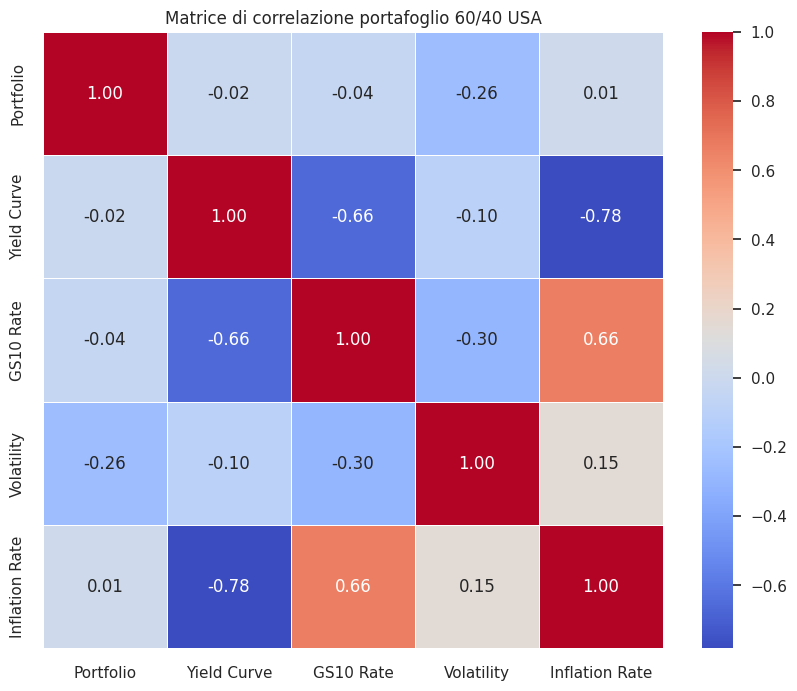

In [10]:
# ANALISI DI CORRELAZIONE

# Creare matrice di correlazione
corr_matrix = monthly_data.corr()

# Heatmap matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Matrice di correlazione portafoglio 60/40 USA')
plt.show()

## Model Performance

- **R² and Generalization**:  
  In terms of performance, the R² coefficient on the training and testing datasets was moderate. These results suggest that the model was able to explain a relatively small portion of the variance in portfolio returns. However, the improvement in R² values on the testing data compared to the training data indicates good generalization capabilities. Although the R² is not particularly high, the predictive accuracy of linear regression proves to be more reliable and less prone to errors compared to the Random Forest model.

- **Impact of Interest Rates and Volatility**:  
  Overall, the coefficients confirm that interest rates and volatility tend to negatively affect portfolio returns. However, the magnitude of this impact remains limited, likely due to the cushioning effect of diversification between equities and bonds.

- **Residual Analysis**:  
  Examining the residuals plot, the dispersion of residuals around the zero line suggests that the model, despite some deviations, captures the relationship between predicted and observed values reasonably well. This improvement is particularly evident in the testing set, where the residuals are more evenly distributed, indicating that the model generalizes better than the Random Forest.


Coefficients: [-0.01149488 -0.00948843 -0.00152918  0.00013985]
Intercept: 0.030589206418939464
R-squared on training data: 0.09211068754443352
R-squared on testing data: 0.19351018749492177


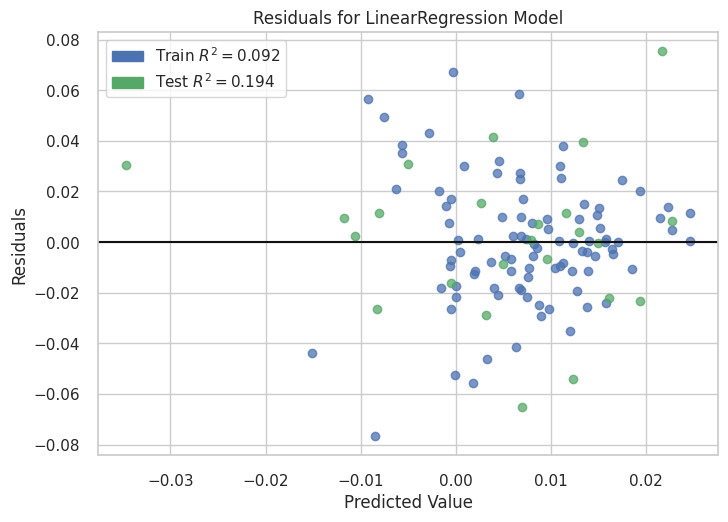

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [11]:
# MACHINE LEARNING MODELS: Regressione lineare, Regressione polinomiale e Random Forest

# Prepariamo i dati
X = monthly_data[['GS10 Rate', 'Yield Curve', 'Volatility','Inflation Rate']]  # Variabili indipendenti
y = monthly_data['Portfolio']  # Variabile dipendente

# Separiamo i dati in training e testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regressione Lineare
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Stampiamo i risultati
print('Coefficients:', linear_model.coef_)
print('Intercept:', linear_model.intercept_)
print('R-squared on training data:', linear_model.score(X_train, y_train))
print('R-squared on testing data:', linear_model.score(X_test, y_test))

# Visualizziamo i residui usando Yellowbrick
visualizer = ResidualsPlot(linear_model, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Polynomial Regression Analysis

- **Performance Comparison**:  
  The polynomial regression model produced results that, at first glance, may appear similar to those of linear regression. However, the inclusion of polynomial terms was expected to capture non-linear relationships between the independent variables (GS10 rate, volatility, yield curve) and portfolio returns. Despite this, the addition of polynomial terms did not improve model performance, confirming the predominantly linear nature of these relationships.

- **Model Overfitting**:  
  Including higher polynomial degrees resulted in overfitting, similar to the issue observed with the Random Forest model. From degree 2 onward, the model over-adapted to the training data, leading to poor predictions on the testing set:
  - **Degree 2**: Negative R² values for both portfolios, with a drastic performance decline on the testing data (e.g., R² = -1.79 for the U.S. portfolio).
  - **Degrees 3 and above**: R² values on the testing data were highly negative, confirming that higher-degree polynomial terms added unnecessary complexity without improving the model.

These findings underscore that introducing additional complexity does not provide value for predicting the returns of 60/40 portfolios. The relationships between macroeconomic variables and portfolio returns are primarily linear, making simpler models more effective for this analysis.


Grado 1:
  Miglior alpha per Ridge Regression: 100.0
  R-squared Training = 0.0478, R-squared Testing = 0.1512
Grado 2:
  Miglior alpha per Ridge Regression: 10.0
  R-squared Training = 0.2547, R-squared Testing = -1.7949
Grado 3:
  Miglior alpha per Ridge Regression: 10.0
  R-squared Training = 0.4153, R-squared Testing = -4.6880
Grado 4:
  Miglior alpha per Ridge Regression: 100.0
  R-squared Training = 0.5877, R-squared Testing = -288.9012
Grado 5:
  Miglior alpha per Ridge Regression: 0.1
  R-squared Training = 0.3976, R-squared Testing = -80.0612

Grado polinomiale ottimale: 1
Miglior R-squared sul set di testing: 0.1512


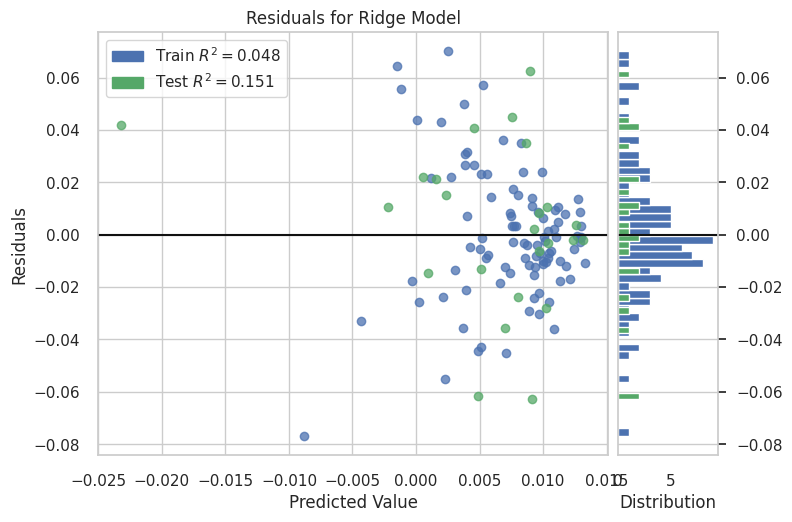

<Axes: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [12]:
# Regressione Polinomiale con Ridge Regression e GridSearchCV

# Lista dei gradi da testare
degrees = [1, 2, 3, 4, 5]

best_degree = 0
best_test_score = float('-inf')

for degree in degrees:
    # Creiamo le features polinomiali
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Modello Ridge con GridSearchCV per ogni grado
    ridge = Ridge()
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_poly, y_train)
    best_ridge = grid_search.best_estimator_

    # Valutazione delle prestazioni
    train_score = best_ridge.score(X_train_poly, y_train)
    test_score = best_ridge.score(X_test_poly, y_test)

    print(f"Grado {degree}:")
    print("  Miglior alpha per Ridge Regression:", grid_search.best_params_['alpha'])
    print(f"  R-squared Training = {train_score:.4f}, R-squared Testing = {test_score:.4f}")

    # Aggiorna il grado migliore se le prestazioni migliorano
    if test_score > best_test_score:
        best_test_score = test_score
        best_degree = degree
        final_model = best_ridge
        final_poly = poly
        X_train_poly_final = X_train_poly
        X_test_poly_final = X_test_poly

print(f"\nGrado polinomiale ottimale: {best_degree}")
print(f"Miglior R-squared sul set di testing: {best_test_score:.4f}")

# Visualizzazione dei residui per il modello finale
visualizer = ResidualsPlot(final_model)
visualizer.fit(X_train_poly_final, y_train)
visualizer.score(X_test_poly_final, y_test)
visualizer.show()

## Random Forest Regression Analysis

- **Performance Assessment**:  
  Although Random Forest Regression is renowned for capturing complex and non-linear relationships in data, it demonstrated significant limitations when applied to the 60/40 portfolios studied. In terms of performance, the R² coefficient on the training data was moderately acceptable, suggesting that the model could explain some variance in historical data during training. However, the testing data results were disappointing, with negative R² values indicating that the model struggled to generalize to new data and performed worse than a simple average of returns.

- **Model Overfitting**:  
  These results highlight a classic case of overfitting, where the model over-adapted to the training data, capturing not only the underlying relationships but also noise or anomalies within the dataset. This phenomenon is particularly common in highly complex models like Random Forest, which, while powerful for handling datasets with many variables and interactions, can become ineffective when:
  - The data lacks sufficient relevant information.
  - The number of observations is limited.
  - The independent variables are not strongly correlated with the dependent variable.

In this case, the model's depth and complexity did not add significant value. The macroeconomic variables analyzed—such as interest rates and the yield curve—show weak correlations with the returns of 60/40 portfolios, rendering the high complexity of the Random Forest model unnecessary.


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Migliori iperparametri trovati:
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest ottimizzato R-squared on Training Data: 0.43225382314648686
Random Forest ottimizzato R-squared on Testing Data: 0.0022869569754104813
Random Forest ottimizzato MSE on Testing Data: 0.0011177176917247834


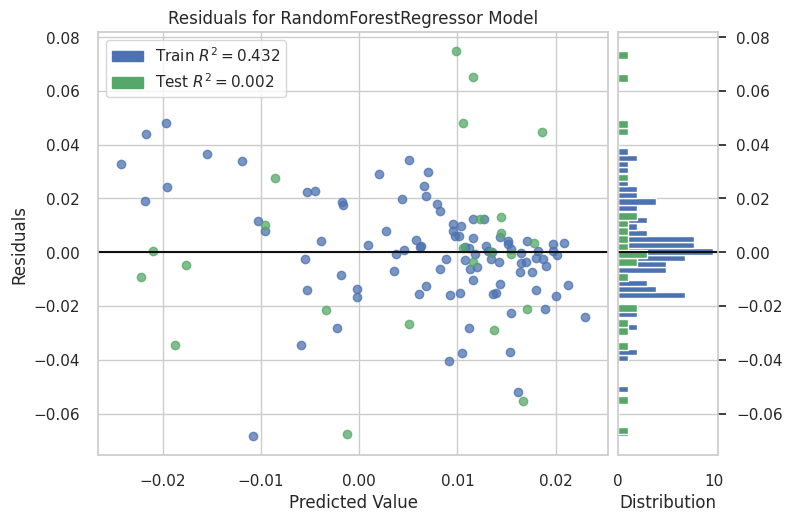

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [13]:
# Random Forest Regression con GridSearchCV

# Definisci la griglia degli iperparametri
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inizializza il modello Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Configura GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='r2', verbose=2)

# Addestra il modello per trovare i migliori iperparametri
grid_search.fit(X_train, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri trovati:")
print(grid_search.best_params_)

# Utilizza il miglior modello
best_rf_model = grid_search.best_estimator_

# Predizioni sul set di training e testing
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Valutazione delle prestazioni
print('Random Forest ottimizzato R-squared on Training Data:', r2_score(y_train, y_train_pred_rf))
print('Random Forest ottimizzato R-squared on Testing Data:', r2_score(y_test, y_test_pred_rf))
print('Random Forest ottimizzato MSE on Testing Data:', mean_squared_error(y_test, y_test_pred_rf))

# Visualizza i residui del modello ottimizzato
visualizer_rf = ResidualsPlot(best_rf_model)
visualizer_rf.fit(X_train, y_train)
visualizer_rf.score(X_test, y_test)
visualizer_rf.show()